In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from scipy.interpolate import Akima1DInterpolator
from scipy import interpolate
from scipy.stats import rv_continuous
from scipy.integrate import quad

# Custom Distributions

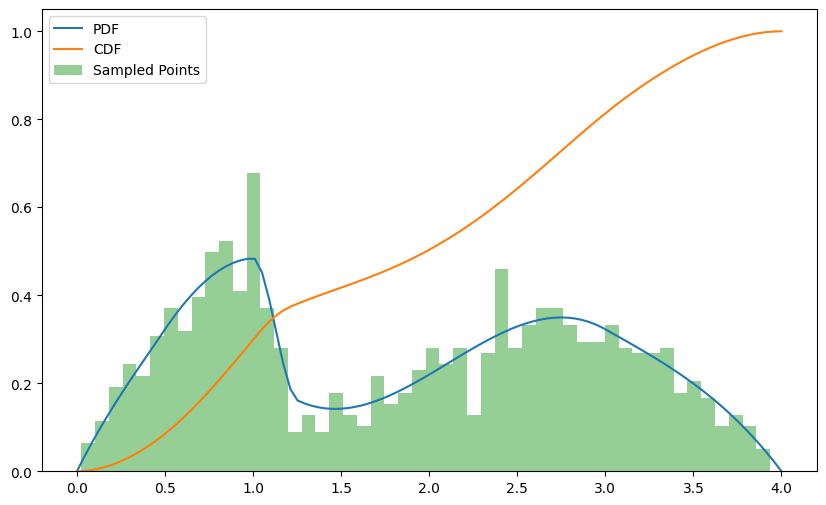

In [2]:
class My6PointsDistribution(rv_continuous):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.x = np.array([0, 0.5, 1, 1.25, 3, 4])
        self.y = np.array([0, 2, 3, 1, 2, 0])
        self.spline = Akima1DInterpolator(self.x, self.y)
        self.integral, _ = quad(self.spline, self.x[0], self.x[-1])
        self.a = self.x[0]
        self.b = self.x[-1]

    def _pdf(self, x):
        return self.spline(x) / self.integral

    def _cdf(self, x):
        try:
            len(x)
            return np.array([quad(self._pdf, self.a, xi)[0] for xi in x])
        except TypeError:
            return quad(self._pdf, self.a, x)[0]

    def _rvs(self, size, random_state):
        u = np.random.rand(size[0])
        samples = np.zeros(size[0])

        # Use inverse interpolation to find x values corresponding to the uniform samples
        # ppf is the percent point function (inverse of cdf — percentiles).
        samples = interpolate.interp1d(
            [self._cdf(x_i) for x_i in np.linspace(self.a, self.b, 200)],
            np.linspace(self.a, self.b, 200),
        )(u)
        return samples

    def _plot(self):
        # PDF and CDF evaluation
        x_eval = np.linspace(0, 4, 100)
        pdf_values = self.pdf(x_eval)
        cdf_values = self.cdf(x_eval)

        # Random sampling (using the inherited rvs method)
        samples = self.rvs(size=1000)

        plt.figure(figsize=(10, 6))

        plt.plot(x_eval, pdf_values, label="PDF")
        plt.plot(x_eval, cdf_values, label="CDF")
        plt.hist(samples, bins=50, density=True, alpha=0.5, label="Sampled Points")
        plt.legend()
        plt.show()


My6PointsDistribution()._plot()

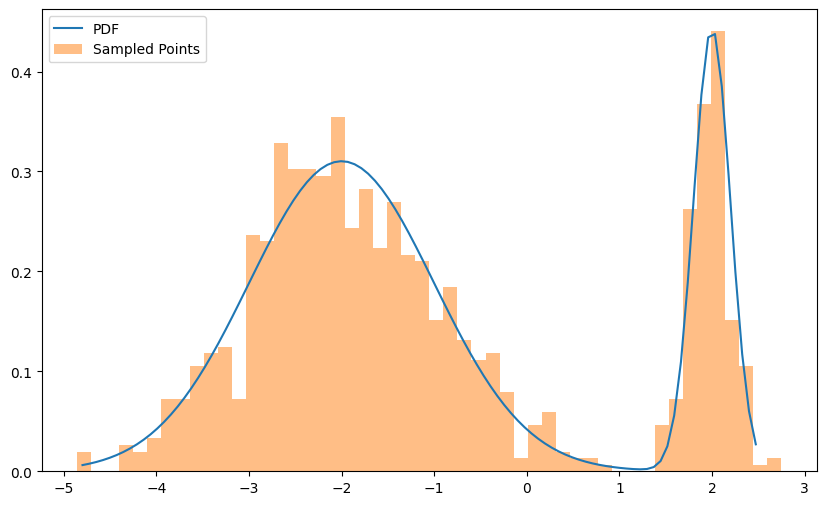

In [3]:
class JointNormal(rv_continuous):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._fac = 175 / (175 + 50)
        self._distr1 = stats.norm(loc=-2, scale=1.0)
        self._distr2 = stats.norm(loc=+2, scale=0.2)

    def _pdf(self, x):
        return self._distr1.pdf(x) * self._fac + self._distr2.pdf(x) * (1 - self._fac)

    def _rvs(self, size, random_state):
        n1 = int(size[0] * self._fac)
        n2 = size[0] - n1
        samples = np.concatenate(
            [
                self._distr1.rvs(size=n1),
                self._distr2.rvs(size=n2),
            ]
        )
        return samples

    def _plot(self):
        # PDF and CDF evaluation
        x_eval = np.linspace(self.ppf(0.002), self.ppf(1 - 0.002), 100)
        pdf_values = self.pdf(x_eval)

        # Random sampling (using the inherited rvs method)
        samples = self.rvs(size=1000)

        plt.figure(figsize=(10, 6))

        plt.plot(x_eval, pdf_values, label="PDF")
        plt.hist(samples, bins=50, density=True, alpha=0.5, label="Sampled Points")
        plt.legend()
        plt.show()


JointNormal()._plot()

# NLL Estimators

## Helpers

## Estimators

In [ ]:
from nll_estimation import (
    nll_hist,
    nll_baseline,
    nll_baseline2,
    nll_kde_fit,
    nll_cdf_fit,
    nll_cdf_fit_monotone,
)

In [6]:
hist_methods = ["extended_ends", "extra_bin", "data_scaled", "samples"]


def nll_hist_mean(samples, data):
    return np.mean([nll_hist(samples, data, method) for method in hist_methods])

In [7]:
from functools import partial

methods = dict(
    baseline=nll_baseline,
    baseline2=nll_baseline2,
    kde_fit=nll_kde_fit,
    cdf_fit=nll_cdf_fit,
    cdf_fit_monotone=nll_cdf_fit_monotone,
)
methods.update(
    {f"hist_{method}": partial(nll_hist, method=method) for method in hist_methods}
)
methods["hist_mean"] = nll_hist_mean

test_distributions = dict(
    norm1=stats.norm(loc=0.0, scale=1.0),
    norm2=stats.norm(loc=3.0, scale=0.01),
    norm3=stats.norm(loc=-5.0, scale=0.1),
    norm4=stats.norm(loc=0.0, scale=10.0),
    norm5=stats.norm(loc=5.0, scale=0.1),
    joint_norm=JointNormal(),
    six_point=My6PointsDistribution(),
)

In [8]:
rng = np.random.default_rng(333)

records = []
for distr_name, distr in test_distributions.items():
    print(f"Testing distribution: '{distr_name}'")
    for run_id in range(30):
        sample_size = rng.choice([10, 20, 40])
        data_size = rng.choice([10, 100])
        samples = distr.rvs(size=sample_size)
        data = distr.rvs(size=data_size)

        real_nll = -distr.logpdf(data).mean()
        for method_name, estimate_nll in methods.items():
            print(f"    Testing method: '{method_name}' ({run_id})")

            nll = estimate_nll(samples, data)
            rel_dev = abs(nll - real_nll) / abs(real_nll)

            records.append(
                dict(
                    distr_name=distr_name,
                    method_name=method_name,
                    sample_size=sample_size,
                    data_size=data_size,
                    nll=nll,
                    real_nll=real_nll,
                    rel_dev=rel_dev,
                )
            )


Testing distribution: 'norm1'
    Testing method: 'baseline' (0)
    Testing method: 'baseline2' (0)
    Testing method: 'kde_fit' (0)
    Testing method: 'cdf_fit' (0)
    Testing method: 'cdf_fit_monotone' (0)
    Testing method: 'hist_extended_ends' (0)
    Testing method: 'hist_extra_bin' (0)
    Testing method: 'hist_data_scaled' (0)
    Testing method: 'hist_samples' (0)
    Testing method: 'hist_mean' (0)
    Testing method: 'baseline' (1)
    Testing method: 'baseline2' (1)
    Testing method: 'kde_fit' (1)
    Testing method: 'cdf_fit' (1)
    Testing method: 'cdf_fit_monotone' (1)
    Testing method: 'hist_extended_ends' (1)
    Testing method: 'hist_extra_bin' (1)
    Testing method: 'hist_data_scaled' (1)
    Testing method: 'hist_samples' (1)
    Testing method: 'hist_mean' (1)
    Testing method: 'baseline' (2)
    Testing method: 'baseline2' (2)
    Testing method: 'kde_fit' (2)
    Testing method: 'cdf_fit' (2)
    Testing method: 'cdf_fit_monotone' (2)
    Testing meth

In [9]:
import pandas as pd

df = pd.DataFrame.from_records(records)
df

,distr_name,method_name,sample_size,data_size,nll,real_nll,rel_dev
0,norm1,baseline,10,100,9.791796,1.380751,6.091647
1,norm1,baseline2,10,100,9.855012,1.380751,6.137431
2,norm1,kde_fit,10,100,1.811305,1.380751,0.311826
3,norm1,cdf_fit,10,100,0.224146,1.380751,0.837664
4,norm1,cdf_fit_monotone,10,100,0.226163,1.380751,0.836203
...,...,...,...,...,...,...,...
2095,six_point,hist_extended_ends,40,100,1.364490,1.348346,0.011973
2096,six_point,hist_extra_bin,40,100,2.621293,1.348346,0.944081
2097,six_point,hist_data_scaled,40,100,1.400186,1.348346,0.038447
2098,six_point,hist_samples,40,100,2.889822,1.348346,1.143235


In [10]:
display((df.groupby("method_name")["rel_dev"].mean()).sort_values())
for distr_name, sub_df in df.groupby("distr_name"):
    print("=" * 10, distr_name, "=" * 10)
    display((sub_df.groupby("method_name")["rel_dev"].mean()).sort_values())

method_name
kde_fit               0.108060
hist_extended_ends    0.641586
hist_samples          0.993790
cdf_fit_monotone      1.046716
cdf_fit               1.108664
hist_mean             1.157539
hist_extra_bin        1.514250
hist_data_scaled      1.593109
baseline              1.676244
baseline2             1.731812
Name: rel_dev, dtype: float64

========== joint_norm ==========


method_name
kde_fit               0.265480
hist_extended_ends    0.554477
hist_samples          0.721532
hist_mean             0.742927
hist_data_scaled      0.767376
cdf_fit_monotone      0.998395
hist_extra_bin        1.018519
cdf_fit               1.023944
baseline              1.579929
baseline2             1.624872
Name: rel_dev, dtype: float64

========== norm1 ==========


method_name
kde_fit               0.056061
hist_extended_ends    0.347600
hist_samples          0.727142
hist_mean             0.997666
cdf_fit_monotone      1.055673
hist_extra_bin        1.066728
cdf_fit               1.082514
baseline              1.626342
baseline2             1.676694
hist_data_scaled      1.933034
Name: rel_dev, dtype: float64

========== norm2 ==========


method_name
kde_fit               0.037571
hist_extended_ends    0.378658
hist_samples          0.550023
cdf_fit               0.691536
cdf_fit_monotone      0.697989
hist_mean             0.722299
hist_extra_bin        0.971827
hist_data_scaled      1.081687
baseline              1.222342
baseline2             1.245859
Name: rel_dev, dtype: float64

========== norm3 ==========


method_name
kde_fit               0.091838
hist_extended_ends    1.262973
cdf_fit_monotone      1.632452
cdf_fit               1.693334
hist_samples          1.901130
hist_mean             2.235610
baseline              2.594770
baseline2             2.699194
hist_extra_bin        2.811732
hist_data_scaled      3.130263
Name: rel_dev, dtype: float64

========== norm4 ==========


method_name
kde_fit               0.042681
hist_extended_ends    0.152216
hist_samples          0.325901
cdf_fit_monotone      0.342288
cdf_fit               0.366767
hist_mean             0.378028
hist_extra_bin        0.417444
baseline              0.640787
hist_data_scaled      0.648917
baseline2             0.661244
Name: rel_dev, dtype: float64

========== norm5 ==========


method_name
kde_fit               0.135907
hist_extended_ends    1.303846
hist_samples          1.427907
cdf_fit_monotone      1.542593
cdf_fit               1.855001
hist_mean             1.975192
baseline              2.078159
baseline2             2.164329
hist_data_scaled      2.603011
hist_extra_bin        2.739938
Name: rel_dev, dtype: float64

========== six_point ==========


method_name
kde_fit               0.126879
hist_extended_ends    0.491331
hist_data_scaled      0.987473
cdf_fit               1.047553
hist_mean             1.051047
cdf_fit_monotone      1.057620
hist_samples          1.302898
hist_extra_bin        1.573564
baseline              1.991379
baseline2             2.050491
Name: rel_dev, dtype: float64

joint_norm


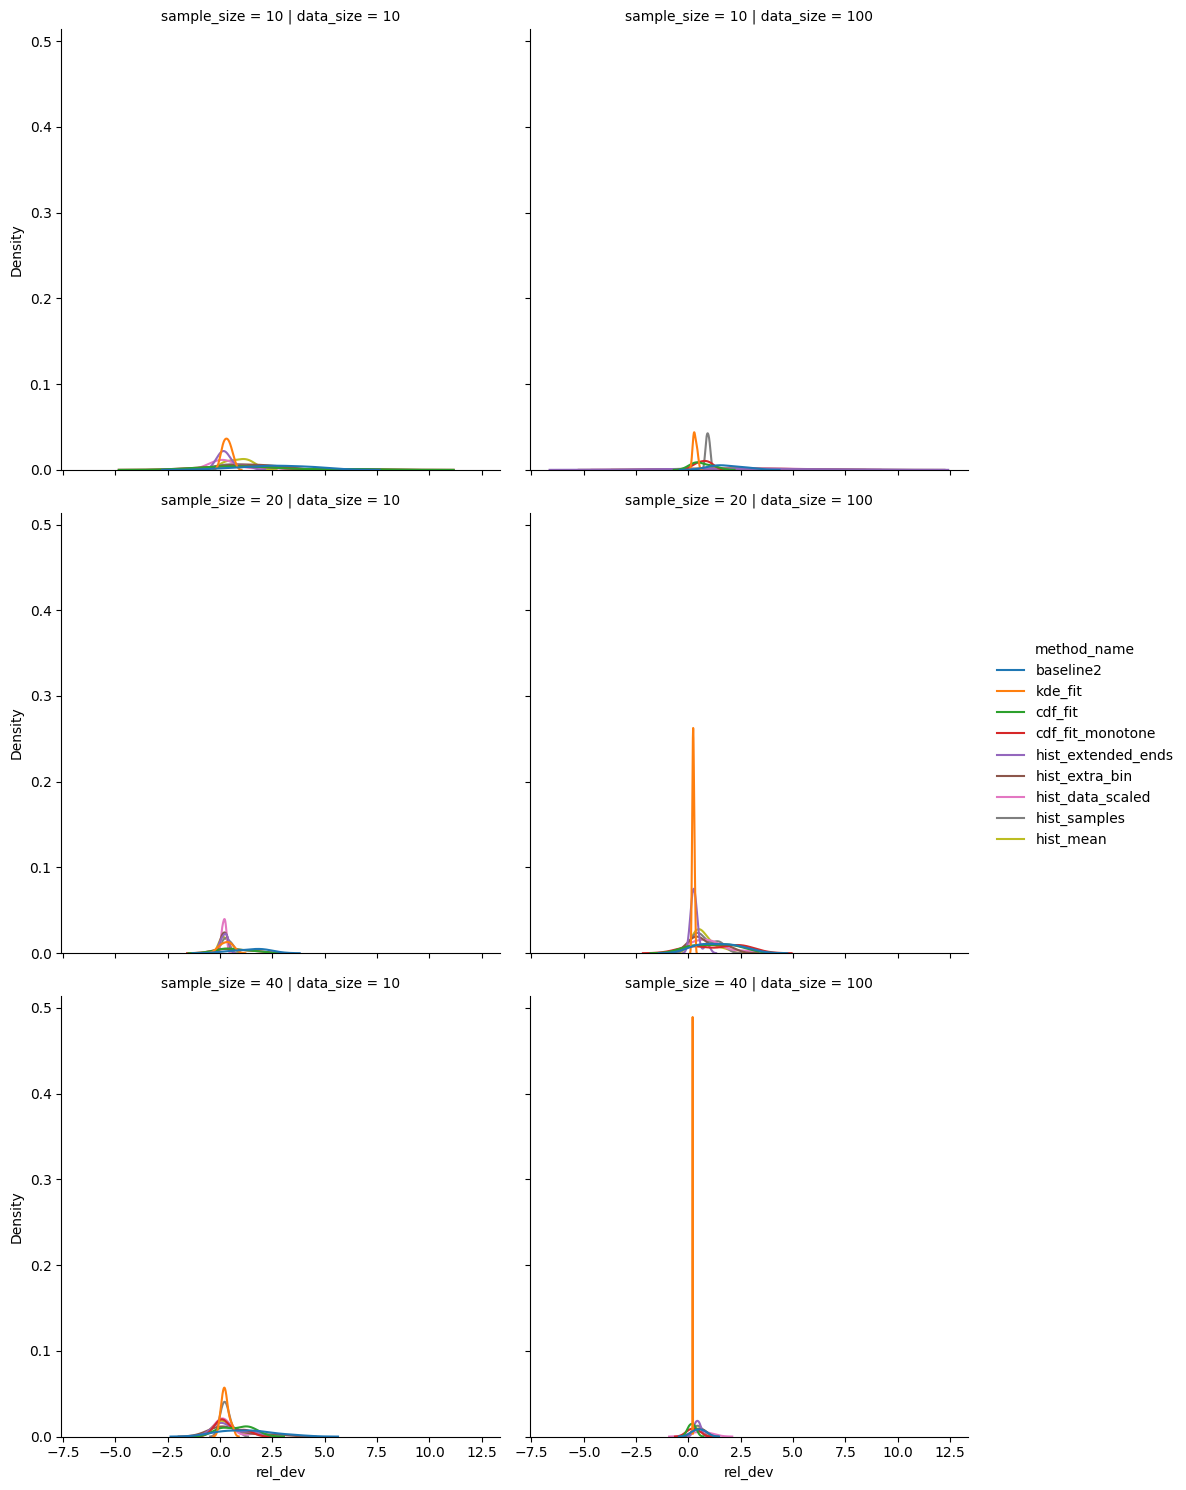

norm1


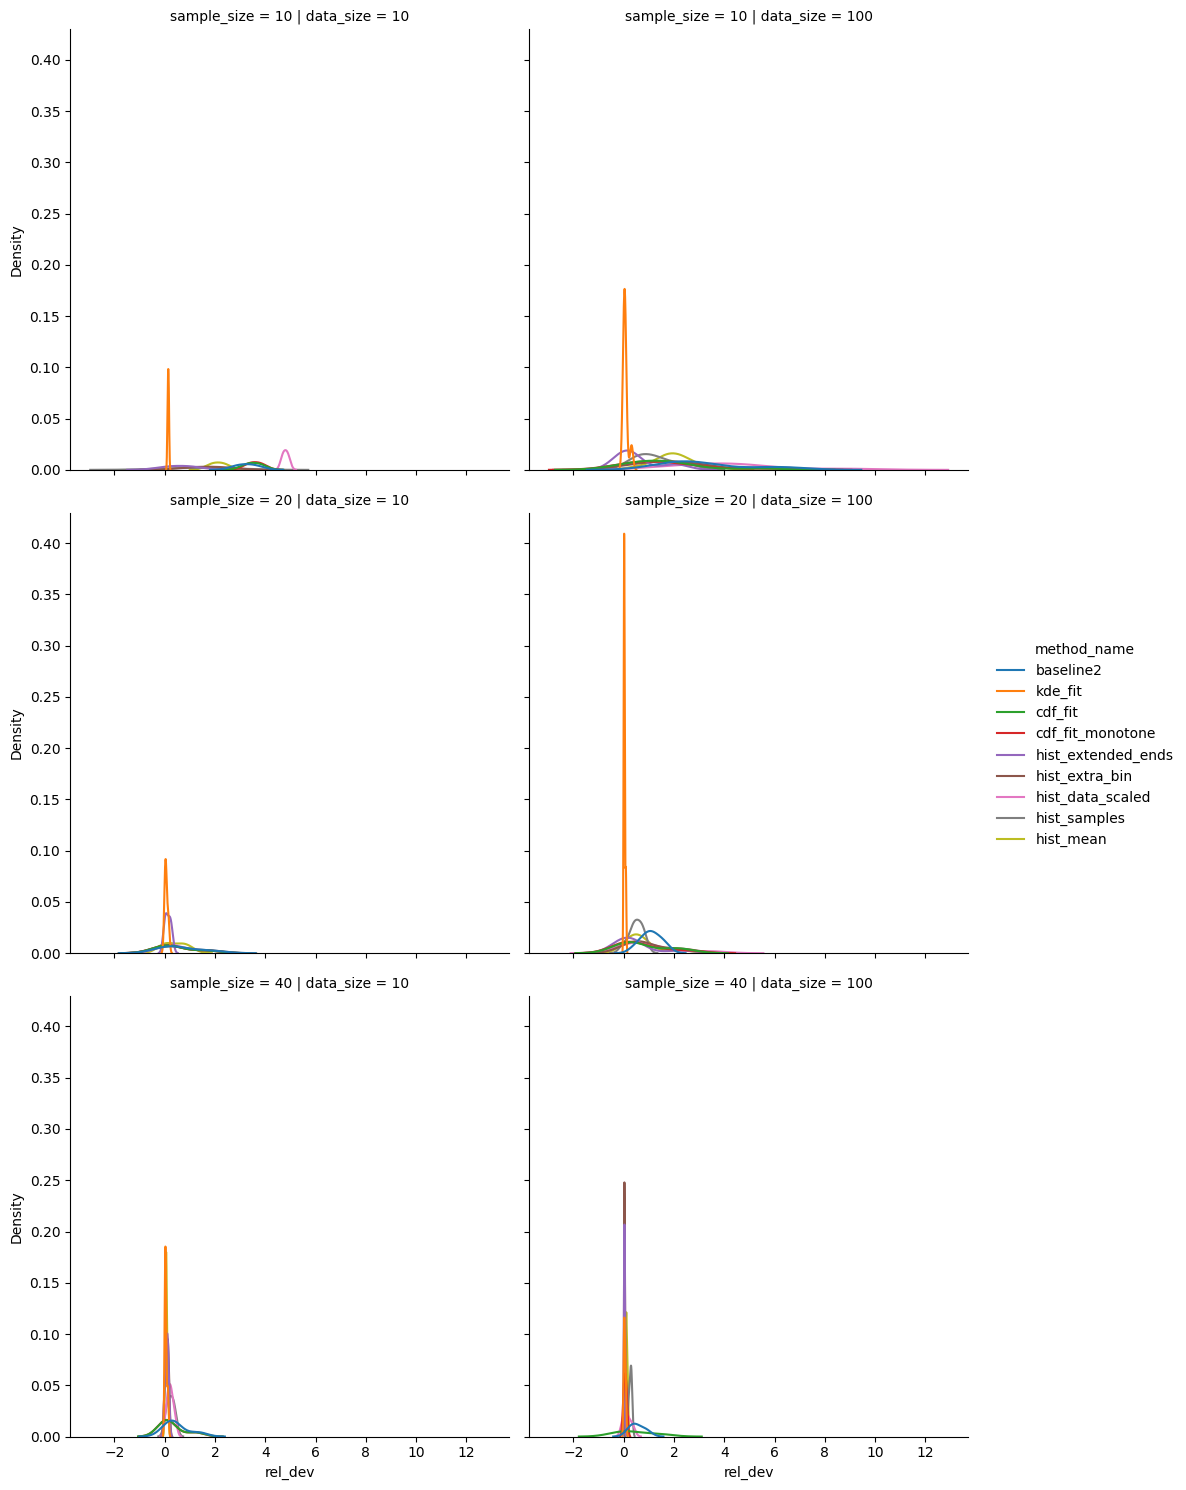

norm2


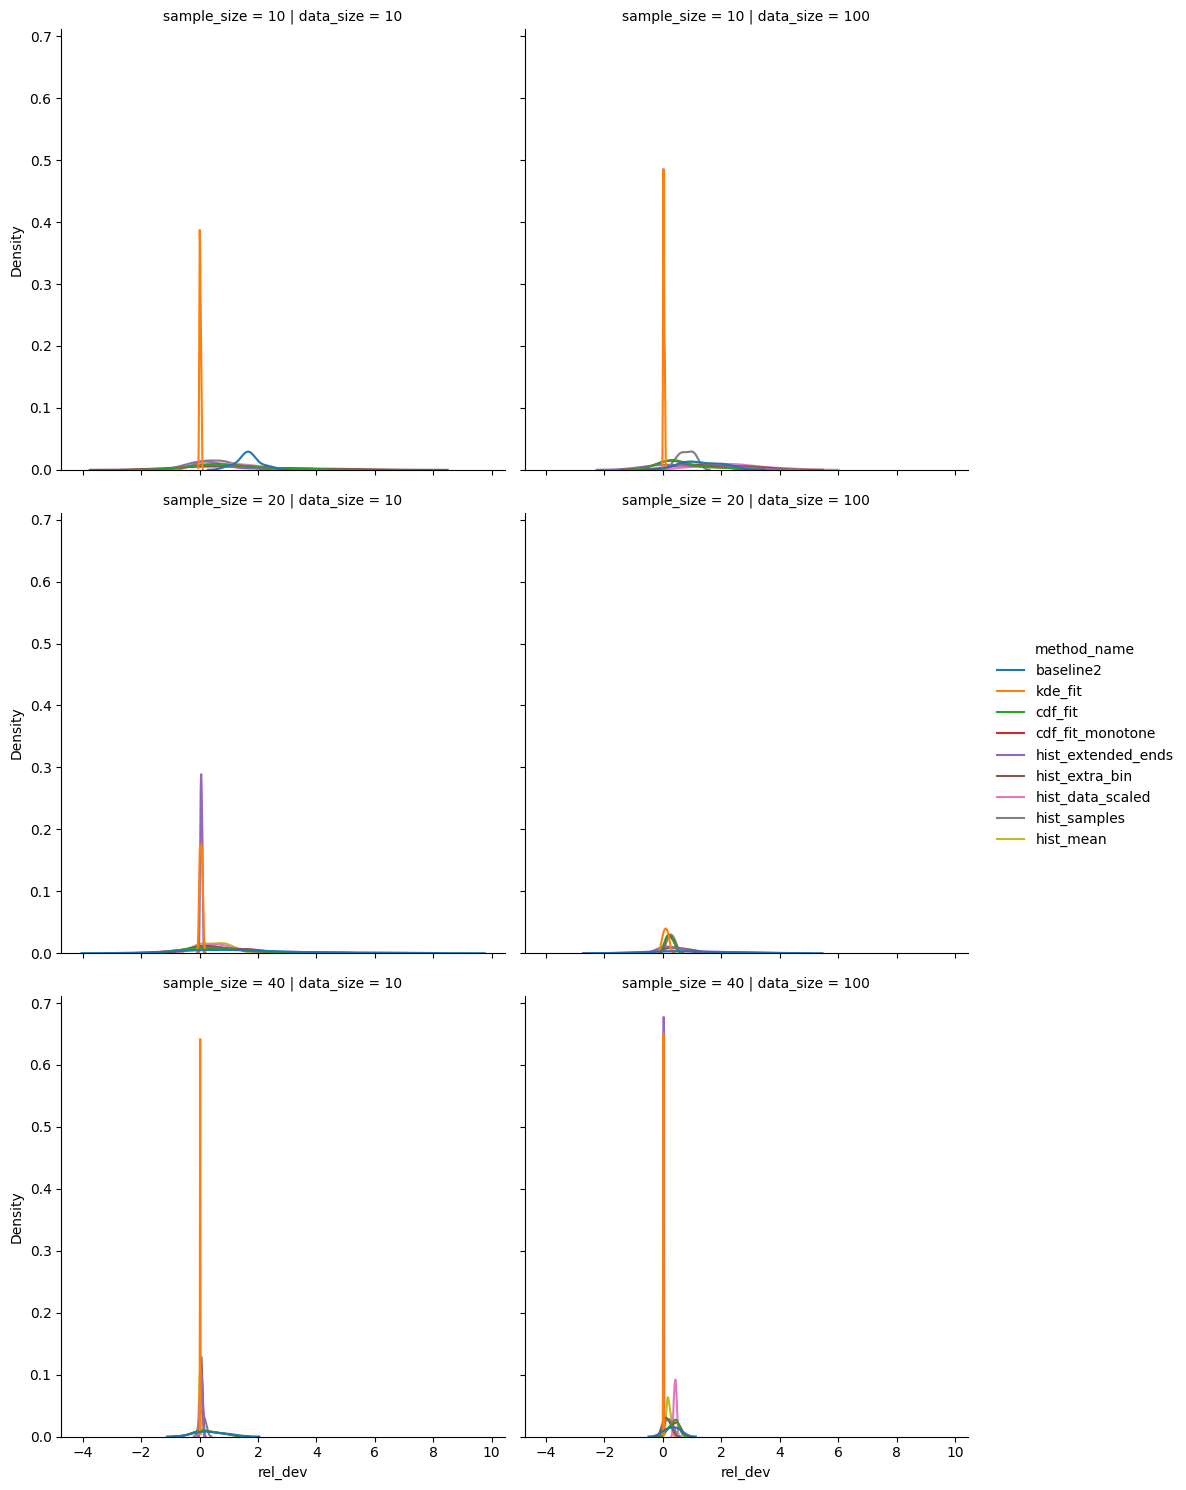

norm3


/var/folders/9k/pz7sq18n26sdjld2rt5h1dr80000gn/T/ipykernel_10890/100576158.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.displot(


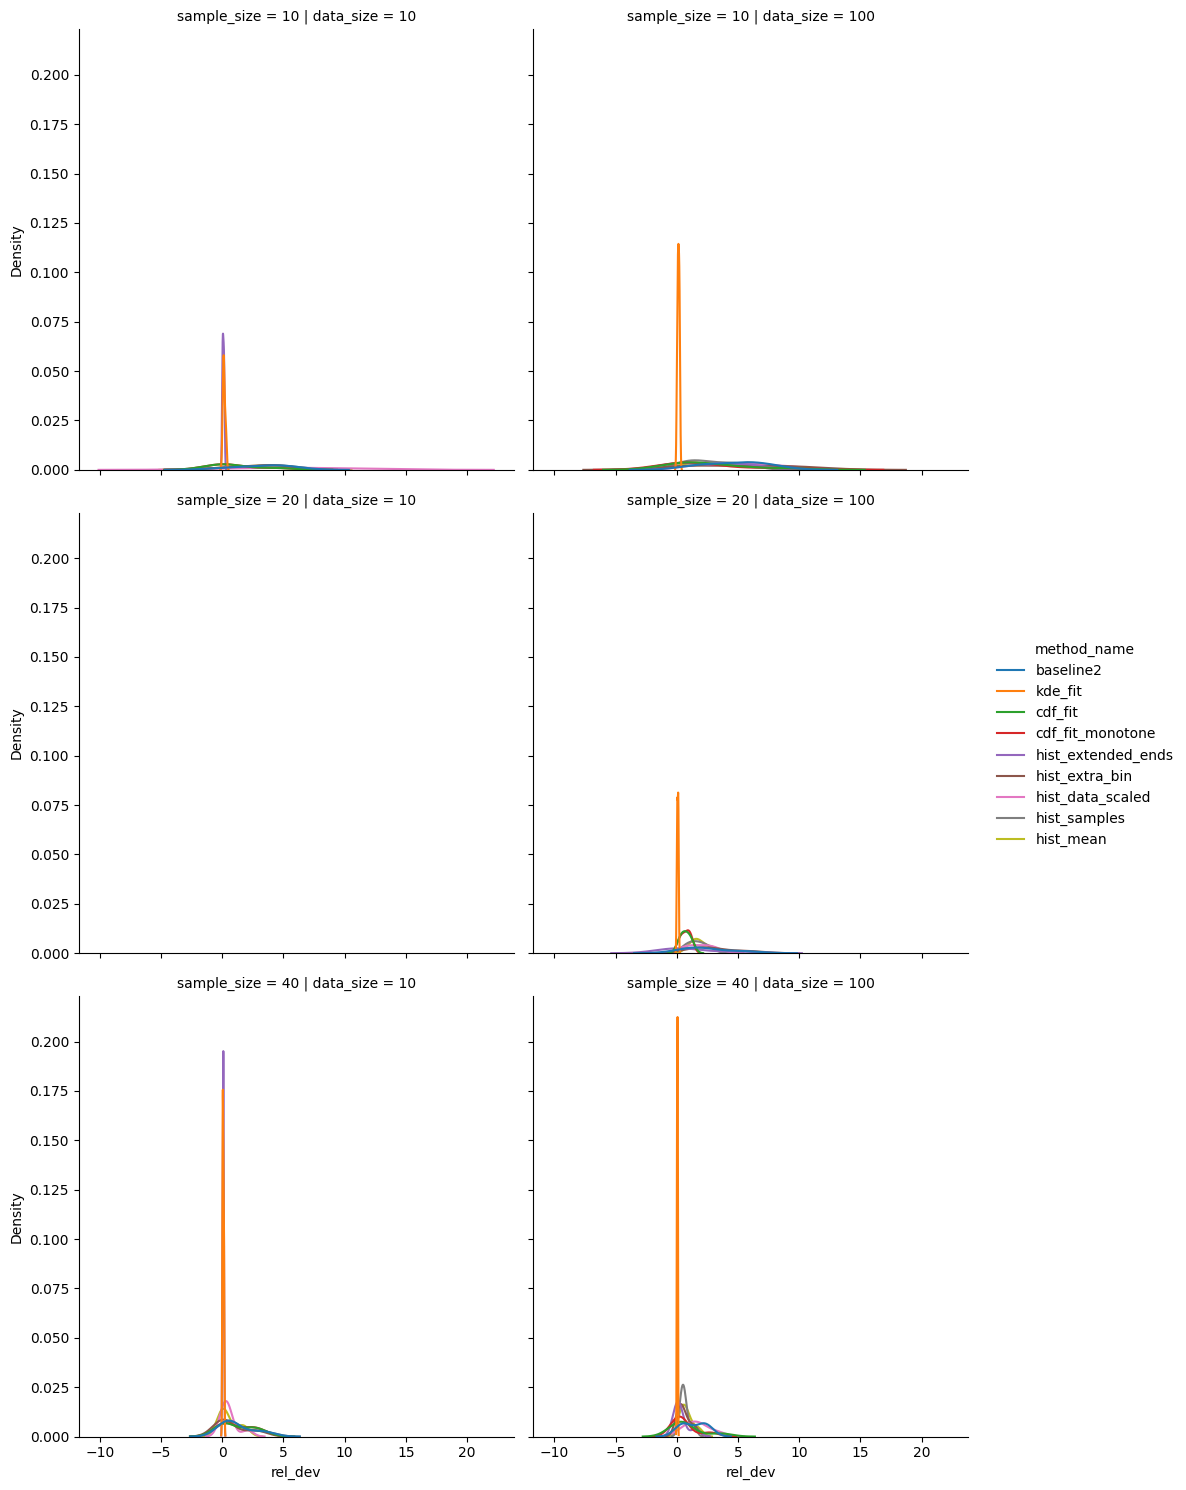

norm4


/var/folders/9k/pz7sq18n26sdjld2rt5h1dr80000gn/T/ipykernel_10890/100576158.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.displot(


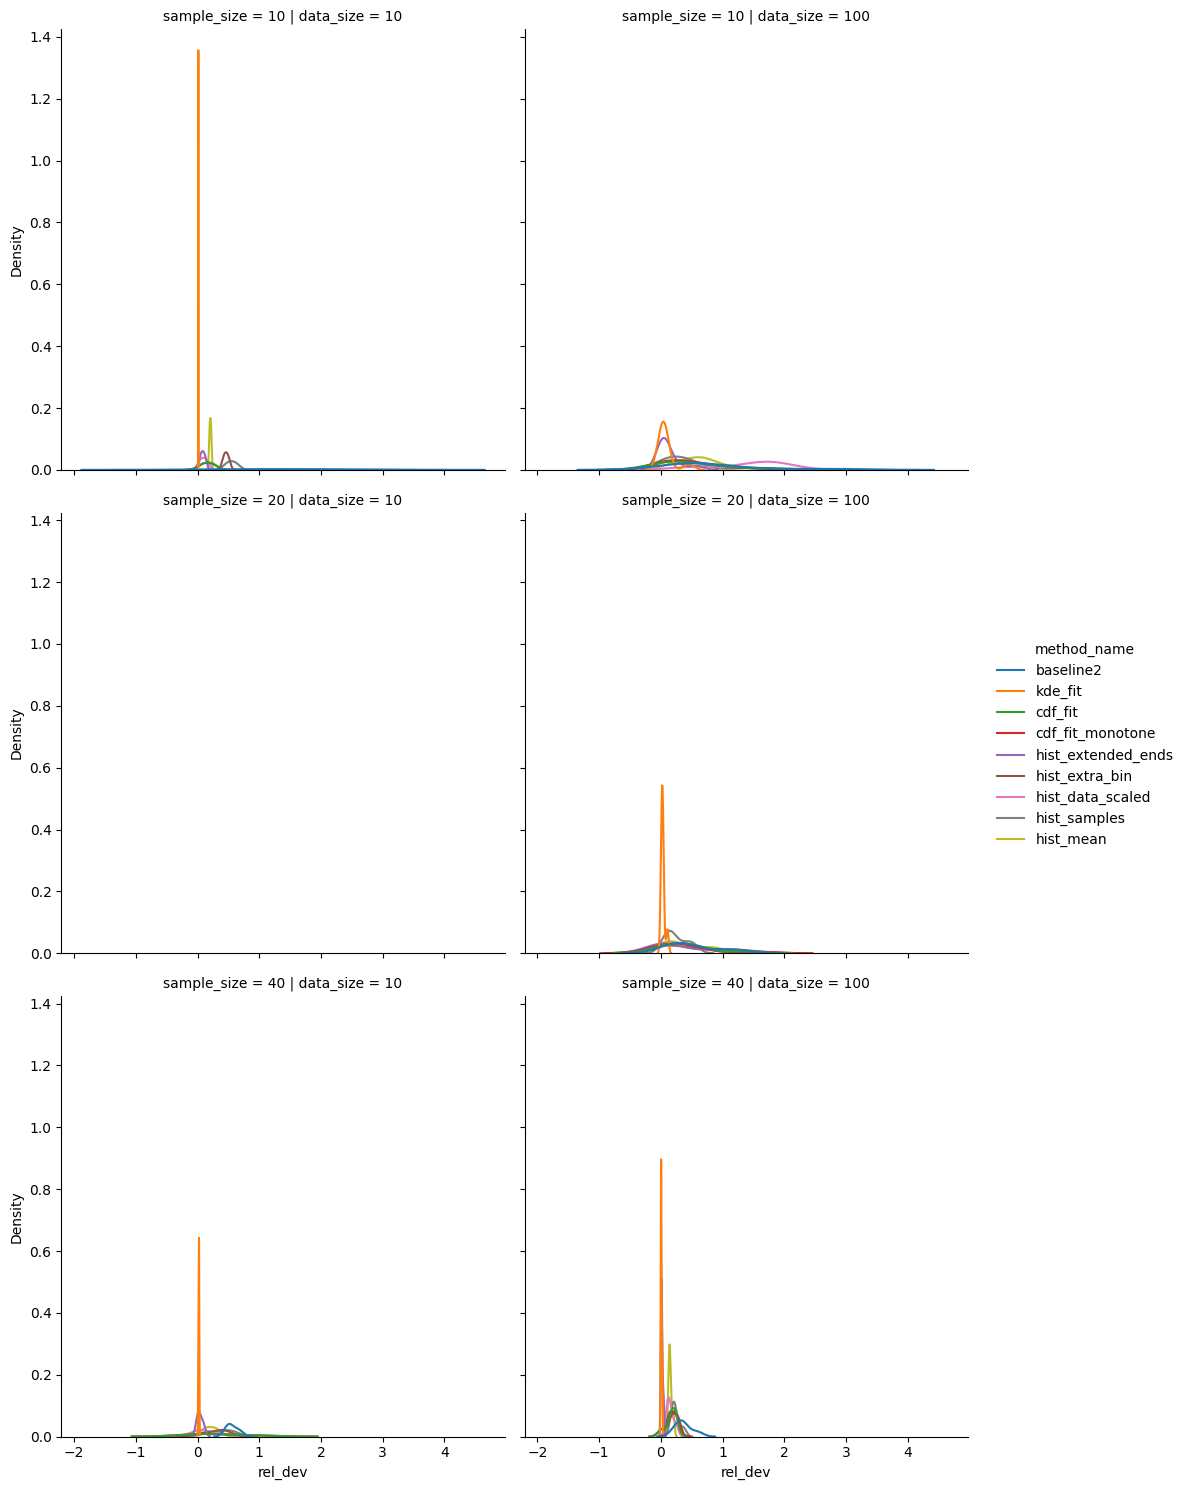

norm5


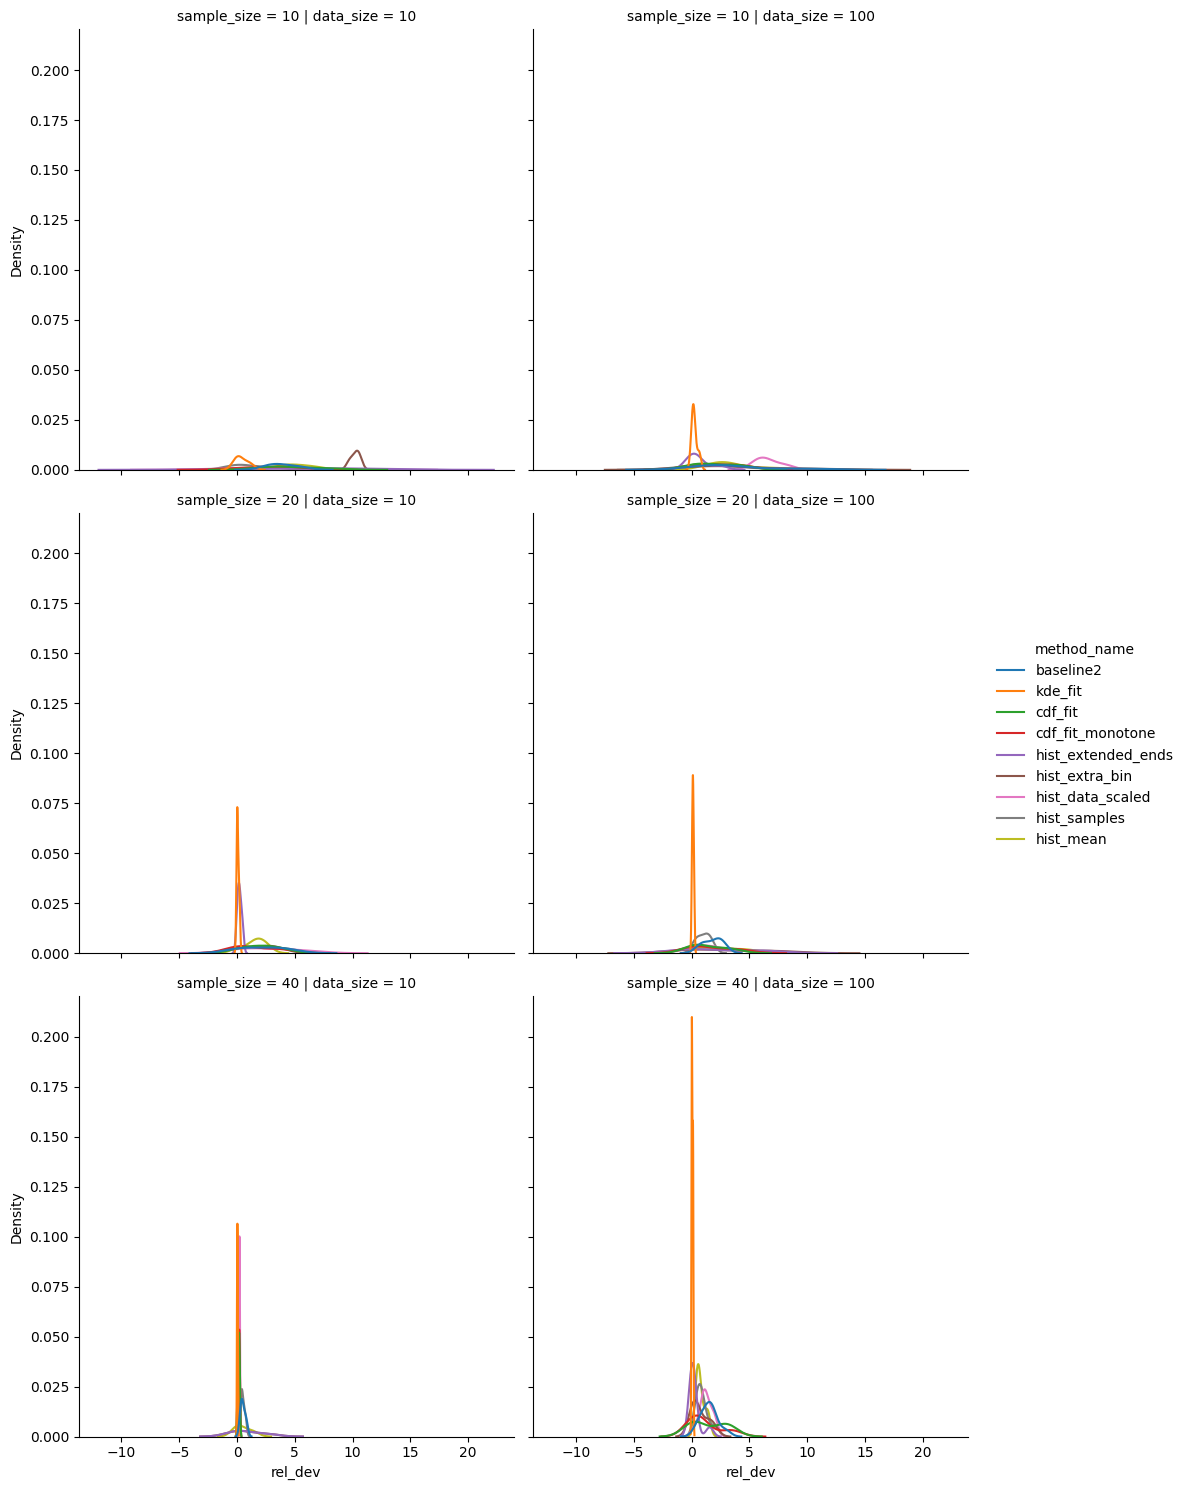

six_point


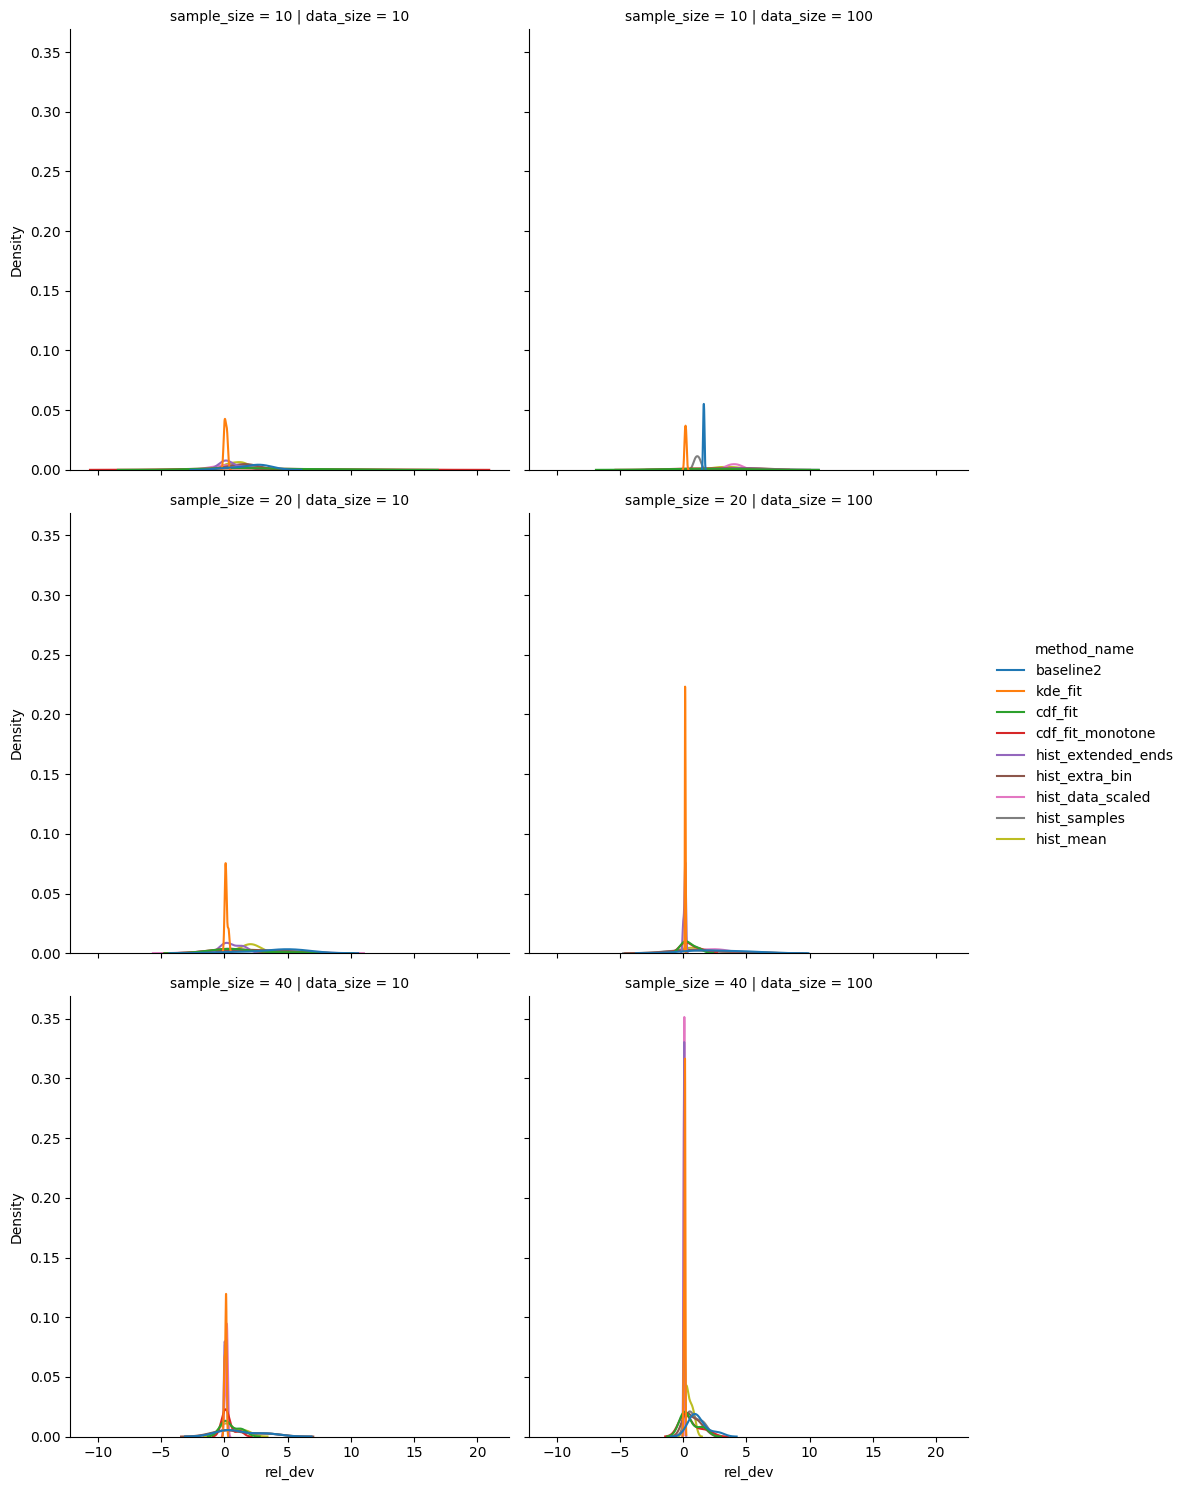

In [11]:
import seaborn as sns

df["y"] = np.random.normal(scale=0.5, size=len(df))
# df = df.loc[df["method_name"] != "baseline"]

for group, sub_df in (df.loc[df["method_name"] != "baseline"]).groupby("distr_name"):
    print(group)
    sns.displot(
        sub_df,
        kind="kde",
        x="rel_dev",
        hue="method_name",
        row="sample_size",
        col="data_size",
    )
    plt.show()